In [2]:
import pandas as pd

yield_rates1 = pd.read_csv('data/bond-yield/yield-curve-rates-1990-2021.csv')
yield_rates2 = pd.read_csv('data/bond-yield/yield-curve-rates-2022.csv')
yield_rates3 = pd.read_csv('data/bond-yield/yield-curve-rates-2023.csv')

frames = [yield_rates3, yield_rates2, yield_rates1]
yield_rates = pd.concat(frames, ignore_index=True)
yield_rates

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,11/30/2023,5.56,5.54,5.45,5.49,5.38,5.16,4.73,4.48,4.31,4.38,4.37,4.72,4.54
1,11/29/2023,5.53,5.52,5.45,5.48,5.38,5.12,4.64,4.40,4.22,4.28,4.27,4.62,4.44
2,11/28/2023,5.53,5.53,5.47,5.45,5.42,5.21,4.73,4.49,4.29,4.36,4.34,4.70,4.52
3,11/27/2023,5.54,5.54,5.49,5.47,5.45,5.24,4.84,4.60,4.38,4.43,4.39,4.72,4.53
4,11/24/2023,5.55,5.56,5.54,5.48,5.45,5.27,4.92,4.67,4.49,4.51,4.47,4.79,4.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,1/8/90,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8483,1/5/90,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8484,1/4/90,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8485,1/3/90,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04


In [3]:
spread_10_2 = []
spread_10_3 = []

for i in range(len(yield_rates)):
    spread_10_2.append(yield_rates.loc[i]['10 Yr'] - yield_rates.loc[i]['2 Yr'])
    spread_10_3.append(yield_rates.loc[i]['10 Yr'] - yield_rates.loc[i]['3 Mo'])

yield_spread = yield_rates.copy()
yield_spread['spread_10_2'] = spread_10_2
yield_spread['spread_10_3'] = spread_10_3

yield_dates = pd.to_datetime(yield_spread['Date'])

new_yield = pd.DataFrame({
    'Date' : yield_dates, 
    'spread_10_2': yield_spread['spread_10_2'], 
    'spread_10_3': yield_spread['spread_10_3']
    })
new_yield 

,Date,spread_10_2,spread_10_3
0,2023-11-30,-0.36,-1.08
1,2023-11-29,-0.37,-1.18
2,2023-11-28,-0.39,-1.13
3,2023-11-27,-0.45,-1.10
4,2023-11-24,-0.45,-1.07
...,...,...,...
8482,1990-01-08,0.12,0.23
8483,1990-01-05,0.09,0.20
8484,1990-01-04,0.06,0.14
8485,1990-01-03,0.05,0.10


In [4]:
stock_symbol = 'MFC.TO'
stock_data = pd.read_csv('data/stocks/{}.csv'.format(stock_symbol))
stock_dates = pd.to_datetime(stock_data['Date'])
# stock_data

new_stock = pd.DataFrame({
    'Date':stock_dates,
    'Adj Close':stock_data['Adj Close']
})
new_stock

,Date,Adj Close
0,1999-09-30,4.075521
1,1999-10-01,4.052165
2,1999-10-04,4.063840
3,1999-10-05,4.040488
4,1999-10-06,4.063840
...,...,...
6116,2023-11-24,26.389999
6117,2023-11-27,26.280001
6118,2023-11-28,26.219999
6119,2023-11-29,26.240000


In [5]:
stock_yield = pd.merge(new_yield, new_stock, how='inner')
df = stock_yield.copy().dropna().iloc[::-1]
df = df.set_index(df['Date'])
df.to_csv('{}_spread.csv'.format(stock_symbol))

In [6]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import t


# df = ry_copy.copy()
# column_2 = 'Dividend Yield' , 'Price/Book'

# training a model to some test dataframe (defined over a time period):
def SLR(df):
    X = df['spread_10_3']
    X_2 = np.array(X).reshape(-1,1)
    y = df['Adj Close']

    regr = linear_model.LinearRegression()
    regr.fit(X_2, y)
    fitted_values = regr.predict(X_2)
    df['Fitted Values'] = fitted_values
    actuals = df['Adj Close']

    plt.scatter(df['spread_10_3'], df['Adj Close'], s=5)
    plt.plot(df['spread_10_3'], df['Fitted Values'], color='red')
    plt.show()

    print('R-Squared: {}'.format(regr.score(X_2,y)))


    print('b0: {}'.format(regr.intercept_))
    print('b1: {}'.format(regr.coef_[0]))
    # print(regr.feature_names_in_)

    residuals = []

    for (i,j) in zip(actuals, fitted_values):
        residuals.append(i - j)

    n = len(df)
    std_error = np.std(residuals)
    critical_value = t.ppf(q = 1 - 0.025, df = n - 2)
    band_width = critical_value * std_error

    return [regr, band_width]


/tmp/ipykernel_3273/2336984005.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fitted Values'] = fitted_values


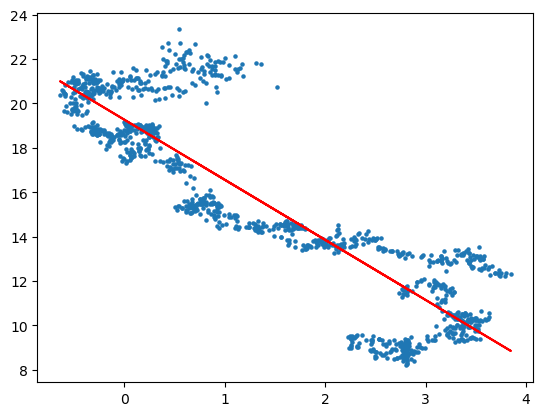

R-Squared: 0.7787604071318108
b0: 19.27018891123273
b1: -2.7080642152368046


[LinearRegression(), 3.89640719369933]

In [44]:
SLR(df['2003':'2007'])

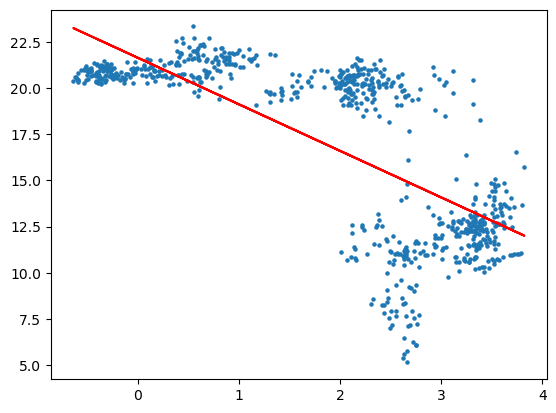

R-Squared: 0.5355908592118981
b0: 21.635894647005202
b1: -2.51977848821214


[LinearRegression(), 6.246245703222664]

In [8]:
gfc = df['2007':'2009'].copy()
gfc.to_csv('{}_gfc_spread.csv'.format(stock_symbol))
SLR(gfc)

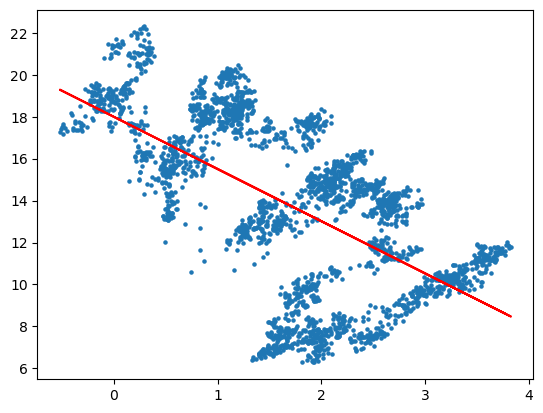

R-Squared: 0.3509135171973723
b0: 17.993076727773698
b1: -2.4867699681257722


[LinearRegression(), 6.35821191647902]

In [9]:
post_gfc = df['2010':'2020'].copy()
post_gfc.to_csv('{}_post_gfc_spread.csv'.format(stock_symbol))
SLR(post_gfc)

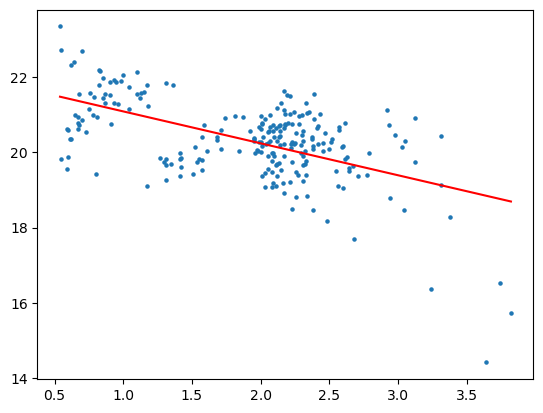

R-Squared: 0.3142435858917271
b0: 21.92910156643568
b1: -0.847678160486537


[LinearRegression(), 1.7464478753004675]

In [10]:
follows_drop = df['2007-10-31' : '2008-10-15'].copy()
SLR(follows_drop)